In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from PIL import Image


In [5]:
DATA_DIR = os.path.join(os.curdir, "data")



./data/raw


In [6]:
TRAIN_SIZE = 0.8
VAL_TEST_RATIO = 0.5
BATCH_SIZE = 32

In [7]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          
    transforms.Normalize(           
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])
#read about stratification
# hint: to keep distribution 

data_dir = os.path.join(os.curdir, "data", "raw","dataset")
dataset = datasets.ImageFolder(data_dir, transform=preprocess)

train_size = int(TRAIN_SIZE * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: './data/raw/dataset'

In [5]:
print(dataset.classes)
print(len(dataset.classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
11


In [6]:
# Load the pre-trained model
model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2", force_reload=False)
# Modify the final layer for 11 classes
num_classes = 11
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Using cache found in /home/mshaker/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# only print at the end of each epoch, add additional information such as recall, precision, and f1 score
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9)

num_epochs = 15
model.train()

train_loss = []
val_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0

    for index , (inputs,labels) in enumerate(train_loader):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_count += 1
    
    epoch_train_loss = running_loss / batch_count
    train_loss.append(epoch_train_loss)
    running_loss = 0.0
    batch_count = 0

    #running validation:
    model.eval()
    val_running_loss = 0.0
    val_batch_count = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_batch_count += 1
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / val_batch_count
    val_loss.append(epoch_val_loss)
    accuracy = val_correct / val_total
    print(f"Epoch {epoch + 1}, Training Loss: {epoch_train_loss:.4f}|| Validation Accuracy: {accuracy:.6f} || Validation Loss: {epoch_val_loss:.6f}")
    #Switching back to training mode
    model.train()


Epoch 1, Training Loss: 2.3016|| Validation Accuracy: 0.399417 || Validation Loss: 2.159690
Epoch 2, Training Loss: 2.0282|| Validation Accuracy: 0.539359 || Validation Loss: 1.875349


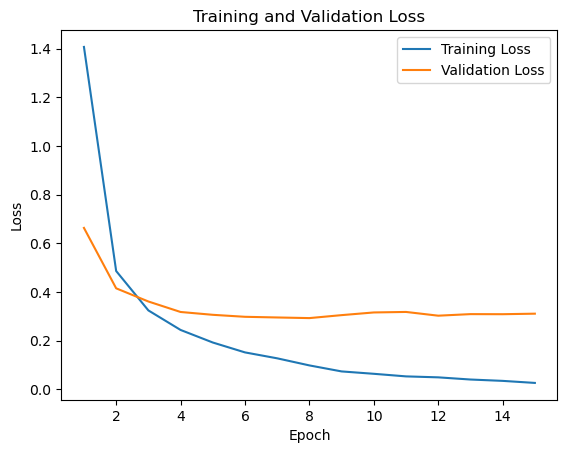

In [ ]:
# Plotting the validation vs training loss curve after training
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

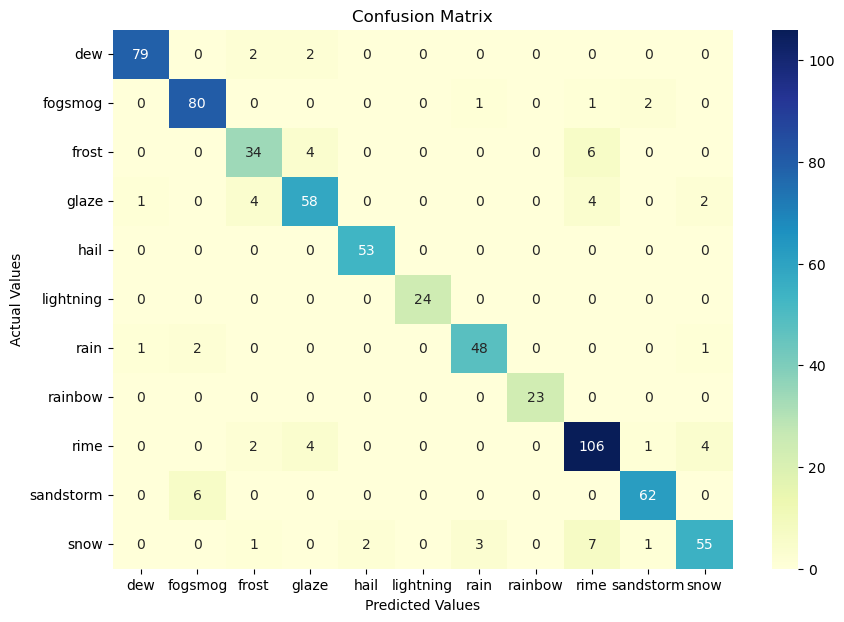

Accuracy: 0.9830
Precision: 0.9067055393586005
Recall: 0.9067055393586005
F1 Score: 0.9067055393586005


In [ ]:
def compute_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    return cm, TP, FP, FN, TN

conf_matrix, TP, FP, FN, TN = compute_metrics(model, val_loader, device)
'''print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")'''

# Visualize the confusion matrix using Seaborn heatmap
cm_df = pd.DataFrame(conf_matrix, index =[i for i in ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']],
                     columns=[i for i in ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']])


plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

accuracy = (TP.sum() + TN.sum()) / (TP.sum() + TN.sum() + FP.sum() + FN.sum())
precision = TP.sum()/(TP.sum() + FP.sum())
recall = TP.sum() / (TP.sum() + FN.sum())
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


In [ ]:
#why is test accuracy a bad measure of performance, what should I use instead, use confusion matrix, F1 score, and recall
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        '''
        if test_total % 160 == 0:
            print(f"Processed {test_total} test samples")
        '''
test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.6f}")

Test Accuracy: 0.922853


why Accuracy is bad?
The accuracy metric computes how many times a model made a correct prediction across the entire dataset. This can be a reliable metric only if the dataset is class-balanced; that is, each class of the dataset has the same number of samples which is not the case in most situations including our own data.

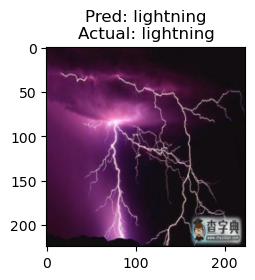

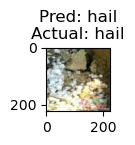

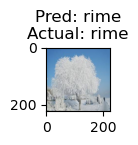

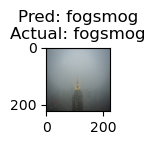

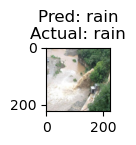

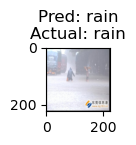

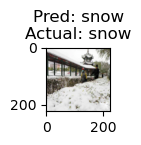

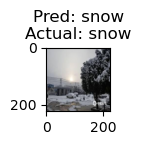

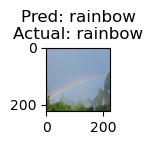

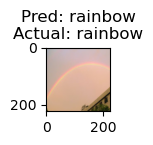

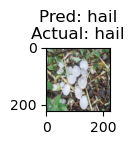

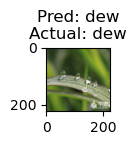

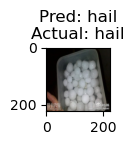

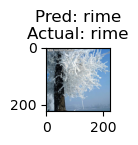

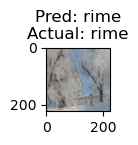

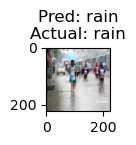

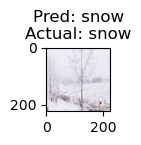

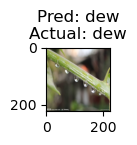

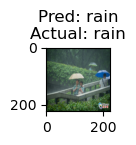

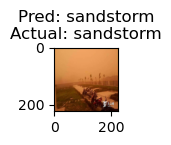

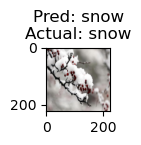

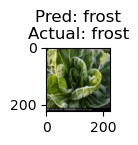

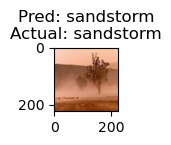

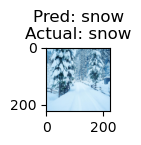

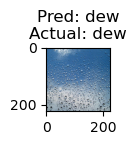

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display images in a grid
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get 25 random images
indices = random.sample(range(len(dataset)), 25)
random_images = [dataset[i] for i in indices]

# Prepare the model for evaluation
model.eval()

# Create a figure
plt.figure(figsize=(15, 15))

# Iterate over the random images
for i, (image, label) in enumerate(random_images):
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    label = torch.tensor([label]).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    # Move image back to CPU for plotting
    image = image.squeeze(0).cpu()
    
    # Display image with title
    ax = plt.subplot(5, 5, i + 1)
    imshow(image, title=f"Pred: {dataset.classes[predicted.item()]}\nActual: {dataset.classes[label.item()]}")
    ax.axis('on')

# Show the plot
plt.show()


In [ ]:
new_image_path = "/mnt/c/Users/malsh/OneDrive - Trinity College/Desktop/IMG classification/test4.webp"

if not os.path.exists(new_image_path):
    print(f"File not found: {new_image_path}")
else:
    new_image = Image.open(new_image_path).convert("RGB")
    new_image = preprocess(new_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    model.eval()
    with torch.no_grad():
        output = model(new_image)
        _, predicted = torch.max(output, 1)

    predicted_label = dataset.classes[predicted.item()]
    print(f"Predicted label for the new image: {predicted_label}")

Predicted label for the new image: fogsmog
